In [2]:

# Acknowledgment:
# This code was developed with assistance from ChatGPT, which provided initial guidance
# and code snippets. Significant modifications and improvements were made by us to 
# ensure the code meets the specific requirements of the project. All optimizations 
# and final adjustments were implemented independently.




# Usual Libraries USED FROM THE OTHER NOTEBOOK WE ADD MORE OR DELETE WHEN NECESSESARRY 
import pandas as pd
import numpy as np
import distutils
import ast

import os
import matplotlib.pyplot as plt
%matplotlib inline

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm import tqdm



# Parsing TFRecord Data and Extracting Features

This code demonstrates how to parse TFRecord files containing audio embeddings and associated labels, transforming them into a DataFrame for further analysis or model training.

### Code Overview:

- **Context Features**: Metadata like video ID and timestamps.
- **Sequence Features**: The audio embeddings, stored as variable-length sequences.
- **Normalization**: The audio embeddings are reshaped and normalized for training.
- **DataFrame Creation**: Collects parsed data and stores it in a Pandas DataFrame.

In [3]:


# Define the context features
context_features = {
    'video_id': tf.io.FixedLenFeature([], tf.string),
    'start_time_seconds': tf.io.FixedLenFeature([], tf.float32),
    'end_time_seconds': tf.io.FixedLenFeature([], tf.float32),
    'labels': tf.io.VarLenFeature(tf.int64)
}

# Define the sequence features
sequence_features = {
    'audio_embedding': tf.io.VarLenFeature(tf.string)
}

def _parse_function(example_proto):
    # Parse the example into context and sequence features
    context_data, sequence_data = tf.io.parse_single_sequence_example(
        example_proto,
        context_features=context_features,
        sequence_features=sequence_features
    )
    
    # Decode the audio embeddings from the byte strings
    audio_embeddings = tf.io.decode_raw(sequence_data['audio_embedding'].values, tf.uint8)
    
    # Check the shape of audio_embeddings and calculate the appropriate reshape
    audio_embeddings = tf.reshape(audio_embeddings, [-1, 128])  # Modify as necessary based on your data
    
    # Normalize the embeddings to the range [0, 1]
    audio_embeddings = tf.cast(audio_embeddings, tf.float32) / 255.0
    
    # Return the 2D reshaped embeddings
    labels = tf.sparse.to_dense(context_data['labels'])
    
    return audio_embeddings, labels  # Return the embeddings as 2D arrays



def parse_tfrecords_to_dataframe(tfrecord_files):
    # Initialize an empty list to store embeddings and labels
    embeddings_list = []
    labels_list = []

    # Iterate through each TFRecord file in the folder
    for tfrecord_file in tqdm(tfrecord_files, desc="Processing TFRecord files"):
        raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
        parsed_dataset = raw_dataset.map(_parse_function)

        # Iterate over the parsed dataset and collect embeddings and labels
        for audio_embedding, labels in parsed_dataset:
            # Convert to numpy arrays
            audio_embedding_np = audio_embedding.numpy()
            labels_np = labels.numpy()

            # Flatten the label array if necessary
            labels_np = labels_np.flatten() if len(labels_np.shape) > 0 else labels_np

            # Store the embedding and label
            embeddings_list.append(audio_embedding_np)
            labels_list.append(labels_np)

    # Create a DataFrame from the collected data
    df = pd.DataFrame({
        'embedding': embeddings_list,
        'labels': labels_list
    })

    return df

# Specify the folder containing TFRecord files
bal_tfrecord_folder = '.github\Data\\bal_train'
bal_tfrecord_files = [os.path.join(bal_tfrecord_folder, f) for f in os.listdir(bal_tfrecord_folder) if f.endswith('.tfrecord')]

eval_tfrecord_folder = '.github\Data\\eval'
eval_tfrecord_files = [os.path.join(eval_tfrecord_folder, f) for f in os.listdir(eval_tfrecord_folder) if f.endswith('.tfrecord')]
eval_df = parse_tfrecords_to_dataframe(eval_tfrecord_files)
# Parse the TFRecords into a DataFrame
bal_df = parse_tfrecords_to_dataframe(bal_tfrecord_files)




Processing TFRecord files: 100%|██████████| 1444/1444 [01:28<00:00, 16.24it/s]



# Save DataFrames to CSV


In [4]:
# Ensure the 'data' directory exists
output_folder = r'.github\Data'
os.makedirs(output_folder, exist_ok=True)

# Paths for saving the CSV files
eval_csv_path = os.path.join(output_folder, 'eval_df.csv')
bal_csv_path = os.path.join(output_folder, 'bal_df.csv')

# Save the DataFrames to CSV
eval_df.to_csv(eval_csv_path, index=False)
bal_df.to_csv(bal_csv_path, index=False)





# Clean Invalid Embeddings

In [78]:
# Function to drop invalid embeddings based on shape
def drop_invalid_embeddings(df):
    valid_entries = []
    
    for i, emb in enumerate(df['embedding']):
        emb_array = np.array(emb)
        if emb_array.shape == (10, 128):  # Only keep valid embeddings
            valid_entries.append(i)
    
    return df.iloc[valid_entries]

# Drop invalid entries from the training set
bal_df_clean = drop_invalid_embeddings(bal_df)

eval_df_clean = drop_invalid_embeddings(eval_df)

# Check the cleaned DataFrame
print(f"Cleaned training set shape: {bal_df_clean.shape}")
print(f"Cleaned test set shape: {eval_df_clean.shape}")



Cleaned training set shape: (7838, 2)
Cleaned test set shape: (7169, 2)


# Multi-Label Binarization and Data Reshaping

In [84]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Convert multi-labels to binary format (one-hot encoding)
y_train = mlb.fit_transform(bal_df_clean['labels'])
y_test = mlb.transform(eval_df_clean['labels'])


X_train = np.array(bal_df_clean['embedding'].tolist()).reshape(-1, 10, 128, 1)
X_test = np.array(eval_df_clean['embedding'].tolist()).reshape(-1, 10, 128, 1)

# Major Key Profiles for Music Scales

In [85]:
# 1 means the notes is apart of the scale, and 0 means that it is not
# The twelve major scales are C C# D D# E F F# G G# A A# B
# EX. C major scale is C D E F G A B which is the first scale in the array
MAJOR_KEY_PROFILES = np.array([
    [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],  # C Major
    [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],  # C# Major
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],  # D Major
    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],  # Eb Major
    [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],  # E Major
    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],  # F Major
    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1],  # F# Major
    [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0],  # G Major
    [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],  # Ab Major
    [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],  # A Major
    [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1],  # Bb Major
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],  # B Major
])

# Probabilistic Key Detection Using Chroma Profiles

In [86]:
import numpy as np
from scipy.stats import norm
#https://cs229.stanford.edu/proj2016/report/Mahieu-DetectingMusicalKeyWithSupervisedLearning-report.pdf
#https://www.kaggle.com/discussions/general/278766 
#https://librosa.org/doc/main/generated/librosa.feature.chroma_cqt.html



def probabilistic_key_detection(chroma_profile, key_profiles):
    """
    Detects the most likely key using a probabilistic approach.
    
    Args:
        chroma_profile (np.array): A 12-dimensional chroma vector (normalized).
        key_profiles (np.array): A 12x12 matrix of major key templates.

    Returns:
        str: The predicted key name.
    """
    # make the sum of all the elements = 1 for consistency 
    chroma_profile = chroma_profile / np.sum(chroma_profile)

    likelihoods = []
    for key_profile in key_profiles:
        # Compute the likelihood by using a guassian noramlization method
        # It finds the difference in squares, and then uses a guassian equation to find the likelihood of the key. 
        likelihood = np.exp(-0.5 * np.sum((chroma_profile - key_profile) ** 2))
        likelihoods.append(likelihood)
    
    # The sum of all probabilities will = 1, so that we can later find the highest probabability key
    likelihoods = np.array(likelihoods)
    likelihoods /= np.sum(likelihoods)

    # Identify the most probable key
    keys = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    # Assigns the highest value likelyhoods of the keys 
    most_likely_key = keys[np.argmax(likelihoods)]
    
    return most_likely_key, likelihoods

# Chroma Feature Extraction from Audio Embedding

In [87]:
import librosa
import librosa.display

def extract_chroma_features(audio_embedding, sr=22050):
    """
    Extracts chroma features from an audio embedding.
    
    Args:
        audio_embedding (np.array): Flattened audio embedding representing a segment.
        sr (int): Sampling rate (default is 22050).
    
    Returns:
        np.array: Normalized 12-dimensional chroma feature.
    """
    # Ensure embedding is in range [-1, 1] as librosa expects audio signals
    audio_embedding = audio_embedding / np.max(np.abs(audio_embedding))

    # Extract chroma features using librosa
    chroma = librosa.feature.chroma_cqt(y=audio_embedding, sr=sr, n_chroma=12)

    # Average across time steps to get a single 12-dimensional vector
    chroma_avg = np.mean(chroma, axis=1)

    # Normalize the chroma profile to sum to 1
    chroma_normalized = chroma_avg / np.sum(chroma_avg)

    return chroma_normalized


# Key Prediction for Dataset Using Probabilistic Approach

In [88]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming `probabilistic_key_detection()` function and `MAJOR_KEY_PROFILES` are defined

# Generate key predictions for the dataset
bal_key_predictions = []
for index, row in bal_df_clean.iterrows():
    # Extract audio embedding
    audio_embedding = np.array(row['embedding'])  # Ensure the embedding is a numpy array

    # Extract chroma features from the embedding
    chroma_profile = extract_chroma_features(audio_embedding)

    # Detect the most likely key and its likelihood distribution
    predicted_key, _ = probabilistic_key_detection(chroma_profile, MAJOR_KEY_PROFILES)

    # Store the predicted key
    bal_key_predictions.append(predicted_key)

# Add predicted keys to the dataframe
bal_df_clean['predicted_key'] = bal_key_predictions
print('bal Done')
eval_key_predictions = []
for index, row in eval_df_clean.iterrows():
    # Extract audio embedding
    audio_embedding = np.array(row['embedding'])  # Ensure the embedding is a numpy array

    # Extract chroma features from the embedding
    chroma_profile = extract_chroma_features(audio_embedding)

    # Detect the most likely key and its likelihood distribution
    predicted_key, _ = probabilistic_key_detection(chroma_profile, MAJOR_KEY_PROFILES)

    # Store the predicted key
    eval_key_predictions.append(predicted_key)
eval_df_clean['predicted_key'] = eval_key_predictions

KeyboardInterrupt: 

# Label Encoding and Data Preprocessing for CNN

In [ ]:
from tensorflow.keras.utils import to_categorical
# Label encode the predicted keys (for training data)
le = LabelEncoder()
y_train = le.fit_transform(bal_df_clean['predicted_key'])

# Reshape the embedding for CNN input (ensure correct dimensions)
X_train = np.array(bal_df_clean['embedding'].tolist()).reshape(-1, 10, 128, 1)

# For test data, use the same LabelEncoder instance (do not fit again)
y_test = le.transform(eval_df_clean['predicted_key'])  # Using transform, not fit_transform
X_test = np.array(eval_df_clean['embedding'].tolist()).reshape(-1, 10, 128, 1)
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)


# CNN Model Architecture for Key Prediction

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Build the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(10, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the results of the convolutional layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))  # For multi-class classification
optimizer = Adam(learning_rate= 0.0001)
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Summary of the model architecture
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 8, 126, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 63, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 2, 61, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 30, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,610 (1.04 MB)

 Trainable params: 273,610 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training for Key Prediction

In [39]:
history = model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test, y_test_one_hot))


Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6712 - loss: 1.1601 - val_accuracy: 0.6789 - val_loss: 1.0823
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6744 - loss: 1.0770 - val_accuracy: 0.6789 - val_loss: 1.0568
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6789 - loss: 1.0466 - val_accuracy: 0.6789 - val_loss: 1.0410
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6838 - loss: 1.0261 - val_accuracy: 0.6789 - val_loss: 1.0372
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6846 - loss: 1.0327 - val_accuracy: 0.6789 - val_loss: 1.0402
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6820 - loss: 1.0327 - val_accuracy: 0.6789 - val_loss: 1.0388
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6788 - loss: 1.0393 - val_accuracy: 0.6789 - val_loss: 1.0470
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6775 - loss: 1.0295 - val_accuracy: 0.

# Plotting Training and Validation Accuracy

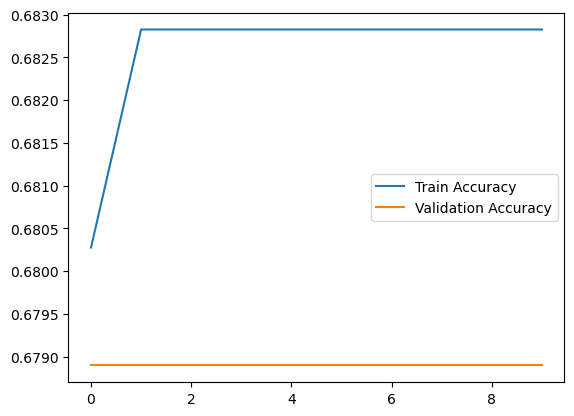

In [40]:

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


# Plotting Class Distribution in Training Set

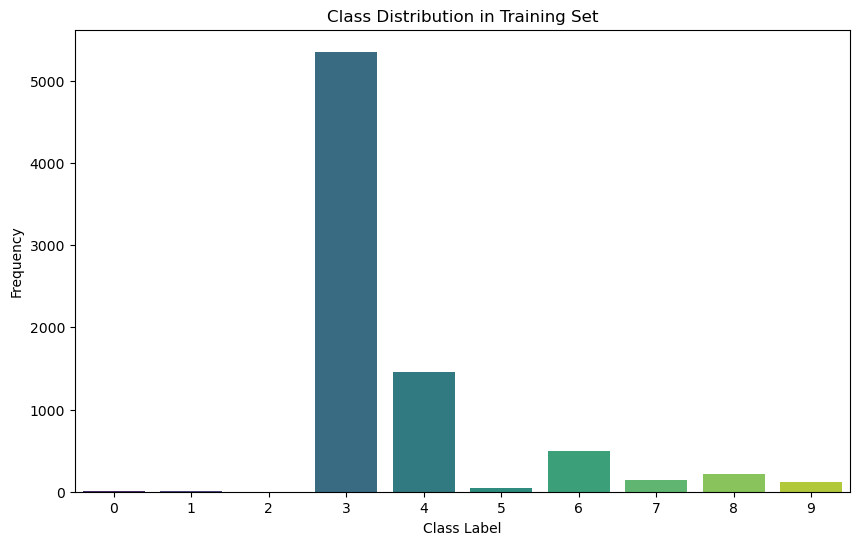

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming y_train is the target variable (the true labels)
# If y_train is encoded as integers, you can directly use the following code

# Count the frequency of each class
unique, counts = np.unique(y_train, return_counts=True)

# Create a DataFrame for easier plotting
import pandas as pd
class_distribution = pd.DataFrame({'Class': unique, 'Frequency': counts})

# Sort the class distribution by class label
class_distribution = class_distribution.sort_values(by='Class')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Frequency', data=class_distribution, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()


# CNN Model with Enhanced Layers and Early Stopping for Multi-Label Classification for Genre Detection

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the CNN model with enhancements
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional Layer 1 with padding and increased filters
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Convolutional Layer 2 with padding and increased filters
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Convolutional Layer 3 with padding and increased filters
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layer with dropout
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout to reduce overfitting

    # Output layer for multi-label classification
    model.add(layers.Dense(num_classes, activation='sigmoid'))  # Sigmoid for multi-label

    return model

# Set input shape and number of classes (labels)
input_shape = (10, 128, 1)  # Shape of each input sample (10, 128, 1)
num_classes = y_train.shape[1]  # Number of unique labels

# Create the CNN model
cnn_model = create_cnn_model(input_shape, num_classes)

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),  # Use a lower learning rate
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

# Display the model architecture
cnn_model.summary()

# Train the model with early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 10, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 64, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 64, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 527)            │       270,351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,599 (2.94 MB)

 Trainable params: 771,599 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.1427 - loss: 0.1211 - val_accuracy: 0.2597 - val_loss: 0.0272
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.2040 - loss: 0.0268 - val_accuracy: 0.1561 - val_loss: 0.0274
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.1981 - loss: 0.0262 - val_accuracy: 0.2933 - val_loss: 0.0273
Epoch 4/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.2208 - loss: 0.0261 - val_accuracy: 0.1601 - val_loss: 0.0270
Epoch 5/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.2165 - loss: 0.0259 - val_accuracy: 0.2198 - val_loss: 0.0267
Epoch 6/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.2481 - loss: 0.0253 - val_accuracy: 0.2417 - val_loss: 0.0265
Epoch 7/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2501 - loss: 0.0253 - val_accuracy: 0.2670 - val_loss: 0.0261
Epoch 8/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.2663 - loss: 0.0249 - 

# Visualizing Training and Validation Accuracy and Loss

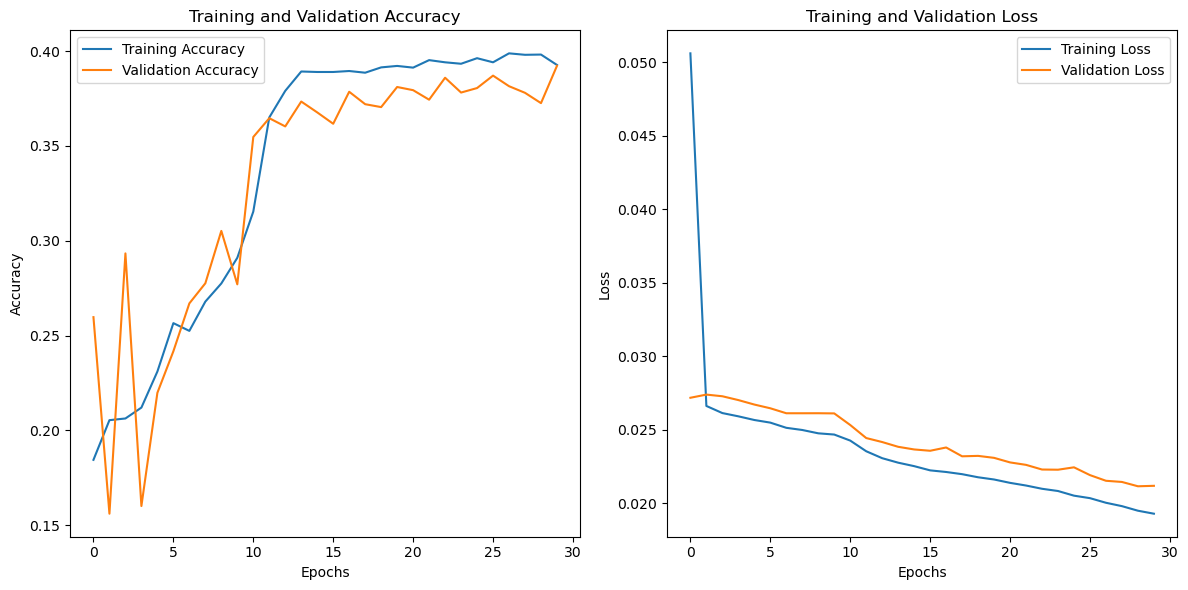

In [50]:
import matplotlib.pyplot as plt

# Get training history
history = cnn_model.history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
